In [1]:
from __future__ import print_function
from copy import deepcopy
import datetime
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import time
import yaml

import pydrake  # MUST BE BEFORE TORCH OR PYRO
import pyro
import pyro.distributions as dist
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import torch.multiprocessing as mp
from tensorboardX import SummaryWriter
from torchviz import make_dot

import scene_generation.data.dataset_utils as dataset_utils
from scene_generation.models.probabilistic_scene_grammar_nodes import *
from scene_generation.models.probabilistic_scene_grammar_nodes_place_setting import *
from scene_generation.models.probabilistic_scene_grammar_model import *
from scene_generation.models.probabilistic_scene_grammar_fitting import *

In [2]:
seed = int(time.time()) % (2**32-1)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.set_default_tensor_type(torch.DoubleTensor)
pyro.enable_validation(True)
pyro.clear_param_store()

hyper_parse_tree = generate_hyperexpanded_parse_tree()
guide_gvs = hyper_parse_tree.get_global_variable_store()
#plt.figure().set_size_inches(20, 20)
#draw_parse_tree(hyper_parse_tree, label_name=True, label_score=False)
#plt.show()

train_dataset = dataset_utils.ScenesDataset("../data/table_setting/table_setting_environments_generated_nominal_train")
test_dataset = dataset_utils.ScenesDataset("../data/table_setting/table_setting_environments_generated_nominal_test")
print("%d training examples" % len(train_dataset))
print("%d test examples" % len(test_dataset))

TypeError: generate_hyperexpanded_parse_tree() missing 1 required positional argument: 'root_node'

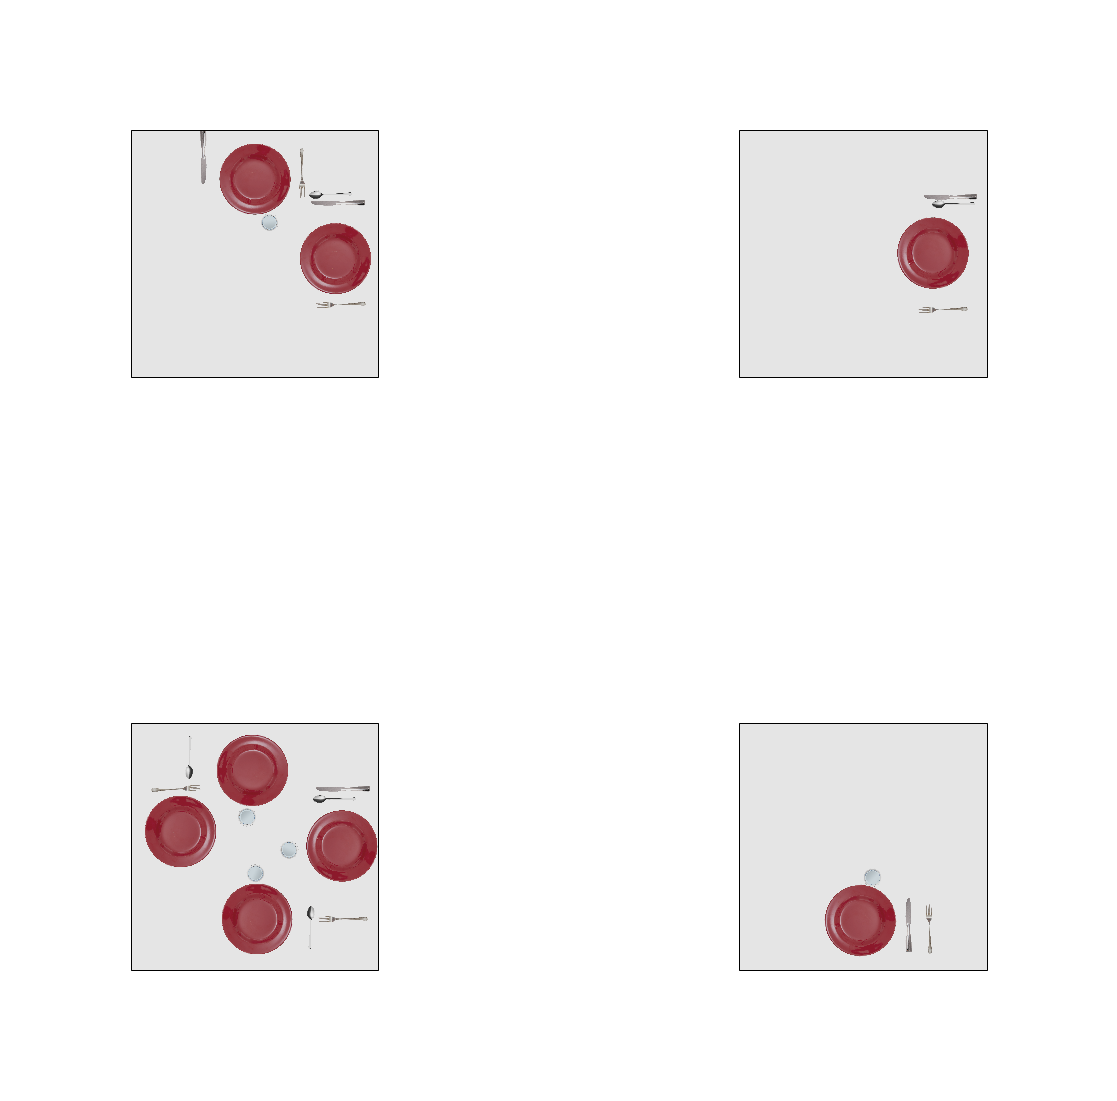

In [6]:
test_parsing_envs = [random.choice(test_dataset) for k in range(4)]
plt.figure().set_size_inches(20, 20)
for k in range(4):
    plt.subplot(2, 2, k+1)
    try:
        DrawYamlEnvironmentPlanarForTableSettingPretty(test_parsing_envs[k], ax=plt.gca())
    except Exception as e:
        print("Failed to draw -- probably empty environment")
    #draw_parse_tree(parse_trees[k], label_name=True, label_score=True, alpha=0.7)

/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


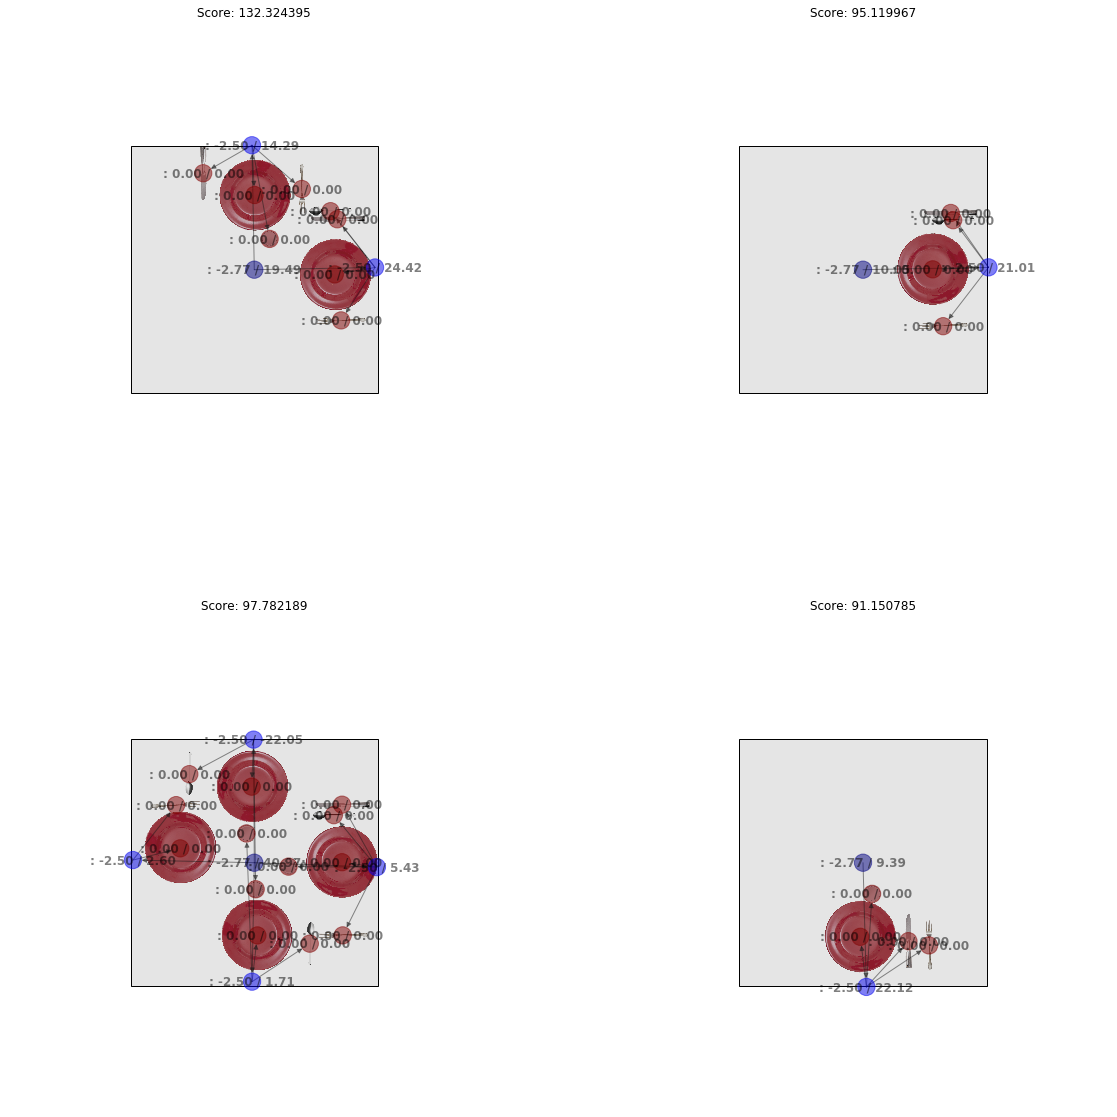

In [7]:
parse_trees = guess_parse_trees_batch_async(test_parsing_envs, guide_gvs=guide_gvs)
#parse_trees = []*4
plt.figure().set_size_inches(20, 20)
for k in range(4):
    plt.subplot(2, 2, k+1)
    plt.xlim(0.1, 0.9)
    plt.ylim(0.1, 0.9)
    #parse_tree, score = guess_parse_tree_from_yaml(test_parsing_envs[k], guide_gvs=guide_gvs, outer_iterations=3, num_attempts=2, verbose=False)
    try:
        DrawYamlEnvironmentPlanarForTableSettingPretty(test_parsing_envs[k], ax=plt.gca())
    except Exception as e:
        print("Failed to draw -- probably empty environment")
    draw_parse_tree(parse_trees[k], label_name=False, label_score=True, alpha=1.0)

In [ ]:
use_writer = True

log_dir = "/home/gizatt/projects/scene_generation/models/runs/psg/table_setting/simple/joint_" + datetime.datetime.now().strftime(
    "%Y-%m-%d-%H-%m-%s")

if use_writer:
    writer = SummaryWriter(log_dir)
    def write_np_array(writer, name, x, i):
        for yi, y in enumerate(x):
            writer.add_scalar(name + "/%d" % yi, y, i)

param_val_history = []
score_history = []
score_test_history = []

# Initialize the guide GVS as mean field
# Note -- if any terminal nodes have global variables associated with
# them, they won't be in the guide.
for var_name in guide_gvs.keys():
    guide_gvs[var_name][0] = pyro.param(var_name + "_est",
                                        guide_gvs[var_name][0],
                                        constraint=guide_gvs[var_name][1].support)
# do gradient steps
print_param_store()
best_loss_yet = np.infty

# setup the optimizer
adam_params = {"lr": 0.001, "betas": (0.8, 0.95)}
all_params_to_optimize = set(pyro.get_param_store()._params[name] for name in pyro.get_param_store().keys())
# Ensure everything in pyro param store has zero grads
for p in all_params_to_optimize:
    assert(p.requires_grad == True)
    p.grad = torch.zeros(p.shape)
    p.share_memory_()
    p.grad.share_memory_()

def per_param_callable(module_name, param_name):
    if "var" in param_name or "weights" in param_name:
        return {"lr": 0.01, "betas": (0.8, 0.95)}

    else:
        return {"lr": 0.001, "betas": (0.8, 0.95)}
optimizer = Adam(per_param_callable)
baseline = 0.
baseline = 0.


snapshots = {}
total_step = 0
for step in range(500):
    # Synchronize gvs and param store. In the case of constrained parameters,
    # the constrained value returned by pyro.param() is distinct from the
    # unconstrianed value we optimize, so we need to regenerate the constrained value.
    for var_name in guide_gvs.keys():
        guide_gvs[var_name][0] = pyro.param(var_name + "_est")

    loss = calc_score_and_backprob_async(train_dataset, n=10, guide_gvs=guide_gvs, optimizer=optimizer)
    #loss = svi.step(observed_tree)
    score_history.append(loss)

    if (total_step % 10 == 0):
        # Evaluate on a few test data points
        loss_test = calc_score_and_backprob_async(test_dataset, n=10, guide_gvs=guide_gvs)
        score_test_history.append(loss_test)
        print("Loss_test: ", loss_test)

        if loss_test < best_loss_yet:
            best_loss_yet = loss
            pyro.get_param_store().save("best_on_test_save.pyro")

        # Also generate a few example environments
        # Generate a ground truth test environment
        plt.figure().set_size_inches(20, 20)
        for k in range(4):
            plt.subplot(2, 2, k+1)
            parse_tree = generate_unconditioned_parse_tree(initial_gvs=guide_gvs)
            yaml_env = convert_tree_to_yaml_env(parse_tree)
            try:
                DrawYamlEnvironmentPlanar(yaml_env, base_environment_type="table_setting", ax=plt.gca())
            except:
                print("Unhandled exception in drawing yaml env")
            draw_parse_tree(parse_tree, label_name=True, label_score=True)
        if use_writer:
            writer.add_scalar('loss_test', loss_test.item(), total_step)
            writer.add_figure("generated_envs", plt.gcf(), total_step, close=True)

    all_param_state = {name: pyro.param(name).detach().cpu().numpy().copy() for name in pyro.get_param_store().keys()}
    if use_writer:
        writer.add_scalar('loss', loss.item(), total_step)
        for param_name in all_param_state.keys():
            write_np_array(writer, param_name, all_param_state[param_name], total_step)
    param_val_history.append(all_param_state)
    #print("active param names: ", active_param_names)
    print("Place setting plate mean est: ", pyro.param("place_setting_plate_mean_est"))
    print("Place setting plate var est: ", pyro.param("place_setting_plate_var_est"))
    total_step += 1
print("Final loss: ", loss)
print_param_store()

In [ ]:
for step in range(500):
    # Synchronize gvs and param store. In the case of constrained parameters,
    # the constrained value returned by pyro.param() is distinct from the
    # unconstrianed value we optimize, so we need to regenerate the constrained value.
    for var_name in guide_gvs.keys():
        guide_gvs[var_name][0] = pyro.param(var_name + "_est")

    loss = calc_score_and_backprob_async(train_dataset, n=10, guide_gvs=guide_gvs, optimizer=optimizer)
    #loss = svi.step(observed_tree)
    score_history.append(loss)

    if (total_step % 10 == 0):
        # Evaluate on a few test data points
        loss_test = calc_score_and_backprob_async(test_dataset, n=5, guide_gvs=guide_gvs)
        score_test_history.append(loss_test)
        print("Loss_test: ", loss_test)

        if loss_test < best_loss_yet:
            best_loss_yet = loss
            pyro.get_param_store().save("best_on_test_save.pyro")

        # Also generate a few example environments
        # Generate a ground truth test environment
        plt.figure().set_size_inches(20, 20)
        for k in range(4):
            plt.subplot(2, 2, k+1)
            parse_tree = generate_unconditioned_parse_tree(initial_gvs=guide_gvs)
            yaml_env = convert_tree_to_yaml_env(parse_tree)
            try:
                DrawYamlEnvironmentPlanar(yaml_env, base_environment_type="table_setting", ax=plt.gca())
            except:
                print("Unhandled exception in drawing yaml env")
            draw_parse_tree(parse_tree, label_name=True, label_score=True)
        if use_writer:
            writer.add_scalar('loss_test', loss_test.item(), total_step)
            writer.add_figure("generated_envs", plt.gcf(), total_step, close=True)

    all_param_state = {name: pyro.param(name).detach().cpu().numpy().copy() for name in pyro.get_param_store().keys()}
    if use_writer:
        writer.add_scalar('loss', loss.item(), total_step)
        for param_name in all_param_state.keys():
            write_np_array(writer, param_name, all_param_state[param_name], total_step)
    param_val_history.append(all_param_state)
    #print("active param names: ", active_param_names)
    print("Place setting plate mean est: ", pyro.param("place_setting_plate_mean_est"))
    print("Place setting plate var est: ", pyro.param("place_setting_plate_var_est"))
    total_step += 1
print("Final loss: ", loss)
print_param_store()

In [ ]:
use_writer = True

hyper_parse_tree = generate_hyperexpanded_parse_tree()
#plt.figure().set_size_inches(20, 20)
#draw_parse_tree(hyper_parse_tree, label_name=True, label_score=False)
#plt.show()

train_dataset = dataset_utils.ScenesDataset("../data/table_setting/table_setting_environments_simple_train")
test_dataset = dataset_utils.ScenesDataset("../data/table_setting/table_setting_environments_simple_test")
print("%d training examples" % len(train_dataset))
print("%d test examples" % len(test_dataset))


log_dir = "/home/gizatt/projects/scene_generation/models/runs/psg/table_setting/" + datetime.datetime.now().strftime(
    "%Y-%m-%d-%H-%m-%s")

if use_writer:
    writer = SummaryWriter(log_dir)
    def write_np_array(writer, name, x, i):
        for yi, y in enumerate(x):
            writer.add_scalar(name + "/%d" % yi, y, i)

env = train_dataset[1]

score_history = []

# Initialize the guide GVS as mean field
guide_gvs = hyper_parse_tree.get_global_variable_store()
# Note -- if any terminal nodes have global variables associated with
# them, they won't be in the guide.
for var_name in guide_gvs.keys():
    guide_gvs[var_name][0] = pyro.param(var_name + "_est",
                                        guide_gvs[var_name][0],
                                        constraint=guide_gvs[var_name][1].support)
# do gradient steps
print_param_store()
best_loss_yet = np.infty

# setup the optimizer
all_params_to_optimize = set(pyro.get_param_store()._params[name] for name in pyro.get_param_store().keys())
# Ensure everything in pyro param store has zero grads
for p in all_params_to_optimize:
    assert(p.requires_grad == True)
    p.grad = torch.zeros(p.shape)
    p.share_memory_()
    p.grad.share_memory_()

def per_param_callable(module_name, param_name):
    if "var" in param_name:
        return {"lr": 0.1, "betas": (0.8, 0.95)}

    else:
        return {"lr": 0.001, "betas": (0.8, 0.95)}
optimizer = Adam(per_param_callable)
baseline = 0.


for step in range(500):
    # Synchronize gvs and param store. In the case of constrained parameters,
    # the constrained value returned by pyro.param() is distinct from the
    # unconstrianed value we optimize, so we need to regenerate the constrained value.
    for var_name in guide_gvs.keys():
        guide_gvs[var_name][0] = pyro.param(var_name + "_est")
    loss = calc_score_and_backprob_async([env], n=1, guide_gvs=guide_gvs, optimizer=optimizer)
    #loss = svi.step(observed_tree)
    score_history.append(loss)

    if (step % 5 == 0):
        # Also generate a few example environments
        # Generate a ground truth test environment
        plt.figure().set_size_inches(20, 20)
        for k in range(4):
            plt.subplot(2, 2, k+1)
            parse_tree = generate_unconditioned_parse_tree(initial_gvs=guide_gvs)
            yaml_env = convert_tree_to_yaml_env(parse_tree)
            try:
                DrawYamlEnvironmentPlanar(yaml_env, base_environment_type="table_setting", ax=plt.gca())
            except:
                print("Unhandled exception in drawing yaml env")
            draw_parse_tree(parse_tree, label_name=True, label_score=True)
        if use_writer:
            writer.add_figure("generated_envs", plt.gcf(), step, close=True)

    all_param_state = {name: pyro.param(name).detach().cpu().numpy().copy() for name in pyro.get_param_store().keys()}
    if use_writer:
        writer.add_scalar('loss', loss.item(), step)
        for param_name in all_param_state.keys():
            write_np_array(writer, param_name, all_param_state[param_name], step)
    #print("active param names: ", active_param_names)
    print("Place setting plate mean est: ", pyro.param("place_setting_plate_mean_est"))
    print("Place setting plate var est: ", pyro.param("place_setting_plate_var_est"))
print("Final loss: ", loss)
print_param_store()

In [ ]:
hyper_parse_tree = generate_hyperexpanded_parse_tree()
#plt.figure().set_size_inches(20, 20)
#draw_parse_tree(hyper_parse_tree, label_name=True, label_score=False)
#plt.show()
# Initialize the guide GVS as mean field
guide_gvs = hyper_parse_tree.get_global_variable_store()

In [ ]:
# Generate a ground truth test environment
plt.figure().set_size_inches(20, 20)
images = []
for k in range(10):
    plt.gca().clear()
    trace = poutine.trace(generate_unconditioned_parse_tree).get_trace(guide_gvs)
    parse_tree = trace.nodes["_RETURN"]["value"]        
    score = trace.log_prob_sum()
    yaml_env = convert_tree_to_yaml_env(parse_tree)
    try:
        DrawYamlEnvironmentPlanar(yaml_env, base_environment_type="table_setting", ax=plt.gca())
    except:
        print("Unhandled exception in drawyamlenv")
    #draw_parse_tree(parse_tree, label_name=False, label_score=False)
    plt.title("")
    plt.gca().axis('off')
    images.append(dataset_utils.fig2data(plt.gcf()).copy())
plt.gca().clear()
for im in images:
    plt.imshow(im, alpha=0.5)
plt.gca().axis('off')
plt.show()

In [ ]:
# Generate a ground truth test environment
plt.figure().set_size_inches(20, 20)
images = []
for k in range(4):
    plt.subplot(2, 2, k+1)
    trace = poutine.trace(generate_unconditioned_parse_tree).get_trace(guide_gvs)
    parse_tree = trace.nodes["_RETURN"]["value"]        
    score = trace.log_prob_sum()
    yaml_env = convert_tree_to_yaml_env(parse_tree)
    try:
        DrawYamlEnvironmentPlanar(yaml_env, base_environment_type="table_setting", ax=plt.gca())
    except:
        print("Unhandled exception in drawyamlenv")
    draw_parse_tree(parse_tree, label_name=True, label_score=True)
    plt.gca().axis('off')
plt.show()

In [ ]:
# Trying parsing test set trees with this model
# Generate a ground truth test environment
plt.figure().set_size_inches(20, 20)
images = []
for k in range(4):
    plt.subplot(2, 2, k+1)
    env = random.choice(test_dataset)
    parse_tree, joint_score = guess_parse_tree_from_yaml(
        env, guide_gvs=guide_gvs, outer_iterations=2, num_attempts=3, verbose=False)
    #trace = poutine.trace(generate_unconditioned_parse_tree).get_trace(guide_gvs)
    #parse_tree = trace.nodes["_RETURN"]["value"]        
    #score = trace.log_prob_sum()
    #yaml_env = convert_tree_to_yaml_env(parse_tree)
    try:
        DrawYamlEnvironmentPlanar(env, base_environment_type="table_setting", ax=plt.gca())
    except:
        print("Unhandled exception in drawyamlenv")
    draw_parse_tree(parse_tree, label_name=True, label_score=True)
    plt.gca().axis('off')
plt.show()